# Data Workshop 2 - Part 2

**Instructor:** Jared Brzenski (jabrzenski@ucsd.edu)

**TAs:** Tommy Stone           (thstone@ucsd.edu)

This script reviews how to:
- import netCDF data
- Analyze metadata
- Calculate density of seawater using TEOS-10
- Check differences


This can be run as MATLAB or Python, depending on the environment chosen.

[MATLAB](#MATLAB) is shown first, with MATLAB code blocks starting with the **% MATLAB** header.

[Python](#Python) is shown second, starting from the [**Python**](#Python) header and has **# Python** at the beginning of the code blocks.
If you want to skip to Python, scroll down to the [**Python**](#Python) header!

For MATLAB, run ```pip install jupyter-matlab-proxy``` in your environment and activate MATLAB in the upper right corner.


## MATLAB 

### Import netCDF data
We are going to import the same netCDF data "washington_shelf_data.nc" from the previous lessons.

netCDf is a self-describing data format. Data has associated "metadata" which describes everything a user might want to know about the data. Where it was collected, the units used, expected values, and other relevant details. Let's read in the file, and check out he global metadata attributes


In [1]:
% MATLAB
% read in a netCDF file
% MATLAB is different, in that it reads in only the parts you want, not necessarily the whole thing.
% This is useful for large files.

filename = 'data/washington_shelf_data.nc';

% Lets see a little information about this file
% (We will need this later!)
% info is a struct with members.

info = ncinfo(filename);
for k = 1:length(info.Attributes)
    fprintf('%s: %s\n', info.Attributes(k).Name, string(info.Attributes(k).Value));
end

title: OOI Washington Shelf Surface-Piercing Profiler CTD
source: CE02SHSP-SP001-08-CTDPFJ000-recovered_cspp-ctdpf_j_cspp_instrument_recovered
creation_date: 2024-09-09 19:32:12
sourceUrl: http://oceanobservatories.org/
institution: Ocean Observatories Initiative
Manufacturer: Sea-Bird Electronics
ModelNumber: SBE 49 Fast CAT
SerialNumber: 49-0346
Description: CTD Profiler: CTDPF Series J
latitude: 44.6350
longitude: -124.3059
Owner: Oregon State University
gridded by: Turner Johnson
for use in: SIO Math Workshop 2024


We can read in the different variables in the netCDF file. Additional information about netCDF files can be found using 'ncdump', available on any system that has the netCDF library installed. BONUS: Install netCDF on your system!

In [2]:
% MATLAB
% Read each variable
temp = ncread(filename, 'temp');
sal = ncread(filename, 'sal');
rho = ncread(filename, 'rho');

% Optionally read coordinates if they exist
time = ncread(filename, 'time');
depth = ncread(filename, 'depth');

### Show Temperature profiles, and average temperature profile
We can see the profiles, and quickly find the average profile using "mean"

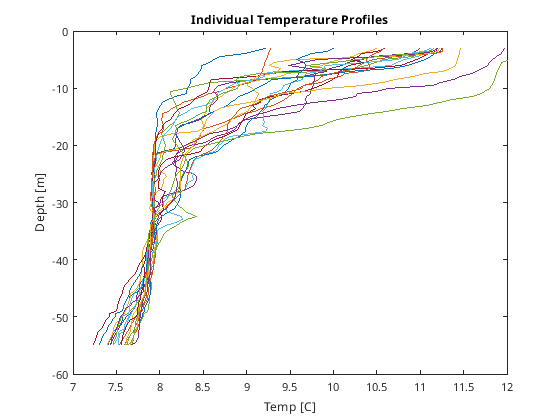

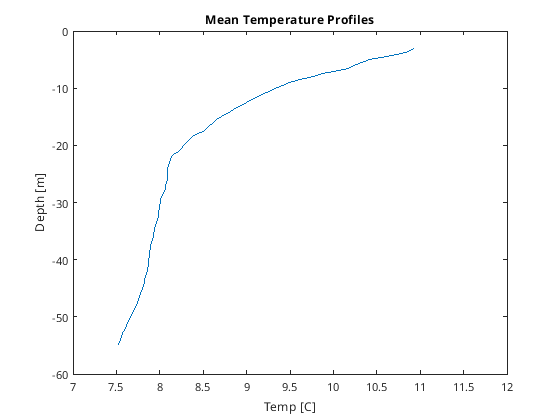

In [3]:
% MATLAB
% Temperature profiles
% Plot each profile, then the average profile
figure(1)
for drop=1:length(time)
    plot(temp(:,drop), depth);
    hold on;
end
xlim([7 12]); xlabel('Temp [C]');
ylim([-60 0]); ylabel('Depth [m]');
title('Individual Temperature Profiles');

figure(2) % Average
temp_mean = mean(temp,2);
plot(temp_mean, depth);
xlim([7 12]); xlabel('Temp [C]');
ylim([-60 0]); ylabel('Depth [m]');
title('Mean Temperature Profiles');


### Show Salinity profiles, and average salinity profile
We can see the profiles, and quickly find the average profile using "mean"

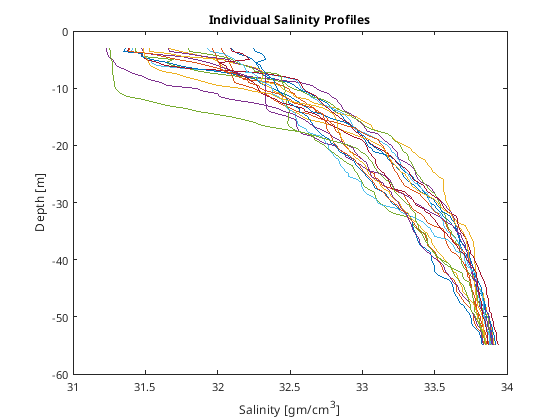

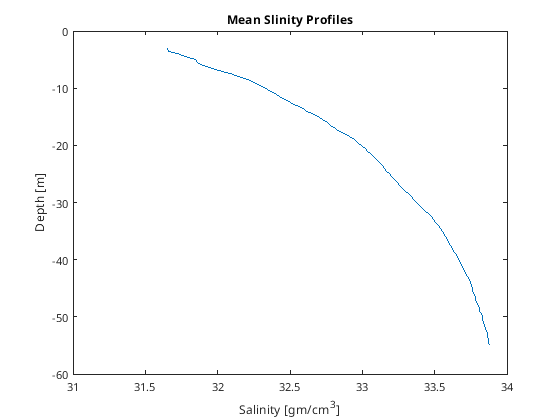

In [4]:
% MATLAB 
% Salinity profiles
% Plot each profile, then the average profile
figure(3)
for drop=1:length(time)
    plot(sal(:,drop), depth);
    hold on;
end
xlim([31 34]); xlabel('Salinity [gm/cm^3]');
ylim([-60 0]); ylabel('Depth [m]');
title('Individual Salinity Profiles');

figure(4) % Average
sal_mean = mean(sal,2);
plot(sal_mean, depth);
xlim([31 34]);  xlabel('Salinity [gm/cm^3]');
ylim([-60 0]); ylabel('Depth [m]');
title('Mean Slinity Profiles');

### Calculate Density
Calculate Density using the [Gibbs-Seawater Oceanographic Toolbox (GSW)](https://www.teos-10.org/software.htm#1)
Include the downloaded files in the MATLAB path, and restart MATLAB. You can also type 'userpath' into the command line to see where that is.

TEOS needs "Absolute Salinity" and "Conservative Temperature". 

The values for lat and lon are taken from the info.attributes of the netCDF file

In [5]:
% MATLAB
% Calculate Density
% Calculate Density using the [Gibbs-Seawater Oceanographic Toolbox (GSW)]

lon = -124.3059;
lat = 44.6350;

% --- Convert depth to pressure ---
p = gsw_p_from_z(depth, lat);

% TEOS needs "Absolute Salinity" and "Conservative Temperature". 
% We can convert from Practical Salinity and in-situ temperature
% to Absolute Salinity and Conservative Temperature
% using the GSW functions
SA = gsw_SA_from_SP(sal, p, lon, lat);
CT = gsw_CT_from_t(SA, temp, p);

% Now we can calculate in-situ density
rho_calc = gsw_rho(SA, CT, p);  % [kg/m^3]

### Checking  and viewing our answer

Lets compare our calculation to the value in the netCDF file, to see if our calculation is equivalent to theirs ( or close enough ).

Max difference between calculated and netCDF density: 0.005115 kg/m^3


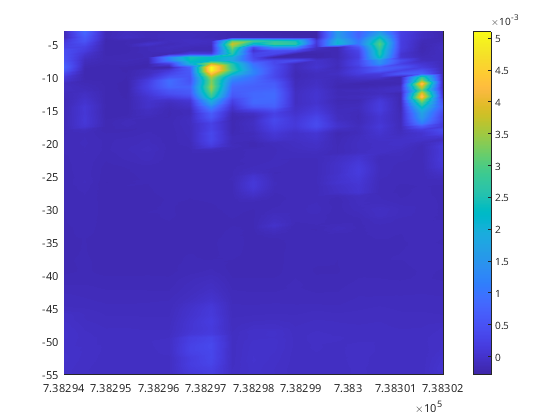

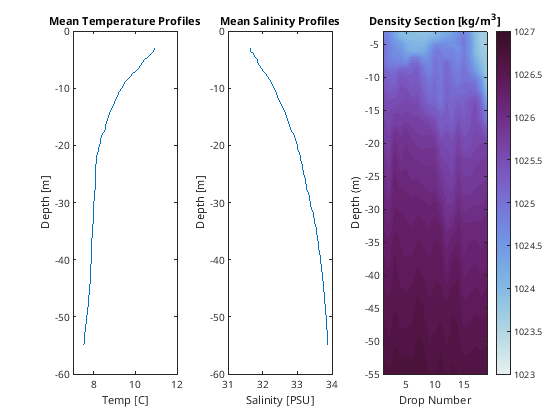

In [8]:
% MATLAB
% Lets check against what the netCDF file says (rho)
diff = rho_calc - rho;
max_diff = max(abs(diff), [], 'all');
fprintf('Max difference between calculated and netCDF density: %f kg/m^3\n', max_diff);

% Plot the difference
figure(99)
pcolor(time, depth, diff); shading interp; colorbar

% Plotting full densities
figure(5)

% Make a filled contour plot (depth vs. time)
% Time is in seconds since 1900, lets just call them "drops 1-19"
drops = [1:length(time)];
contourf(drops, depth, rho, 30, 'LineColor', 'none');

colorbar
cmocean('dense')
caxis([1023 1027])            % adjust to a nice density range
xlabel('Drop Number')
ylabel('Depth (m)')
title('Density Section [kg/m^3]')

### Compare the three profiles

We can compare the average temperature, salinity, and density in one plot.

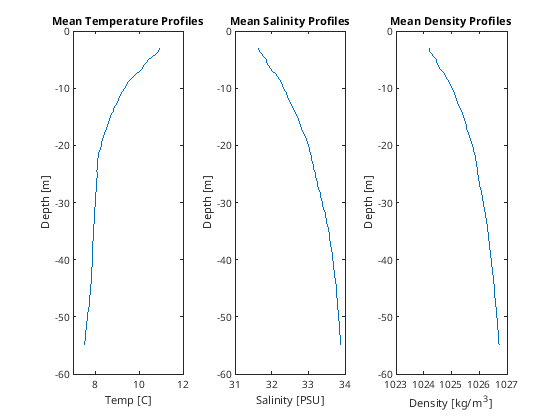

In [7]:
rho_mean = mean(rho_calc,2);
% First axes
px = tiledlayout(1,3);
nexttile
plot(temp_mean, depth);
xlim([7 12]); xlabel('Temp [C]');
ylim([-60 0]); ylabel('Depth [m]');
title('Mean Temperature Profiles');

nexttile
plot(sal_mean, depth);
xlim([31 34]);  xlabel('Salinity [PSU]');
ylim([-60 0]); ylabel('Depth [m]');
title('Mean Salinity Profiles');

nexttile
plot(rho_mean, depth);
xlim([1023 1027]);  xlabel('Density [kg/m^3]');
ylim([-60 0]); ylabel('Depth [m]');
title('Mean Density Profiles');


## Python

### Import netCDF data
We are going to import the same netCDF data "washington_shelf_data.nc" from the previous lessons.

netCDf is a self-describing data format. Data has associated "metadata" which describes everything a user might want to know about the data. Where it was collected, the units used, expected values, and other relevant details. Let's read in the file, and check out he global metadata attributes


In [1]:
# Python
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean    # Colormaps for Oceanography
import gsw        # Gibbs-Seawater Oceanographic Toolbox (GSW)

In [2]:
# Python
# Specify the NetCDF file
filename = 'data/washington_shelf_data.nc'

# Open the dataset using xarray
ds = xr.open_dataset(filename)

# Print global attributes, just show ds
ds

<xarray.Dataset> Size: 49kB
Dimensions:  (time: 19, depth: 105)
Coordinates:
  * time     (time) datetime64[ns] 152B 1900-01-09T13:04:54 ... 1900-01-09T13...
  * depth    (depth) float64 840B -3.0 -3.5 -4.0 -4.5 ... -54.0 -54.5 -55.0
Data variables:
    rho      (time, depth) float64 16kB ...
    sal      (time, depth) float64 16kB ...
    temp     (time, depth) float64 16kB ...
Attributes: (12/14)
    title:          OOI Washington Shelf Surface-Piercing Profiler CTD
    source:         CE02SHSP-SP001-08-CTDPFJ000-recovered_cspp-ctdpf_j_cspp_i...
    creation_date:  2024-09-09 19:32:12
    sourceUrl:      http://oceanobservatories.org/
    institution:    Ocean Observatories Initiative
    Manufacturer:   Sea-Bird Electronics
    ...             ...
    Description:    CTD Profiler: CTDPF Series J
    latitude:       44.6350
    longitude:      -124.3059
    Owner:          Oregon State University
    gridded by:     Turner Johnson
    for use in:     SIO Math Workshop 2024

We can read in the different variables in the netCDF file. Additional information about netCDF files can be found using 'ncdump', available on any system that has the netCDF library installed. BONUS: Install netCDF on your system!

In [3]:
# Python
# Read variables
temp = ds['temp'].values    # shape: depth x time
sal = ds['sal'].values
rho = ds['rho'].values

# Optionally read coordinates
time = ds['time'].values
depth = ds['depth'].values

depth

array([ -3. ,  -3.5,  -4. ,  -4.5,  -5. ,  -5.5,  -6. ,  -6.5,  -7. ,
        -7.5,  -8. ,  -8.5,  -9. ,  -9.5, -10. , -10.5, -11. , -11.5,
       -12. , -12.5, -13. , -13.5, -14. , -14.5, -15. , -15.5, -16. ,
       -16.5, -17. , -17.5, -18. , -18.5, -19. , -19.5, -20. , -20.5,
       -21. , -21.5, -22. , -22.5, -23. , -23.5, -24. , -24.5, -25. ,
       -25.5, -26. , -26.5, -27. , -27.5, -28. , -28.5, -29. , -29.5,
       -30. , -30.5, -31. , -31.5, -32. , -32.5, -33. , -33.5, -34. ,
       -34.5, -35. , -35.5, -36. , -36.5, -37. , -37.5, -38. , -38.5,
       -39. , -39.5, -40. , -40.5, -41. , -41.5, -42. , -42.5, -43. ,
       -43.5, -44. , -44.5, -45. , -45.5, -46. , -46.5, -47. , -47.5,
       -48. , -48.5, -49. , -49.5, -50. , -50.5, -51. , -51.5, -52. ,
       -52.5, -53. , -53.5, -54. , -54.5, -55. ])

### Show Temperature profiles, and average temperature profile
We can see the profiles, and quickly find the average profile using "mean"

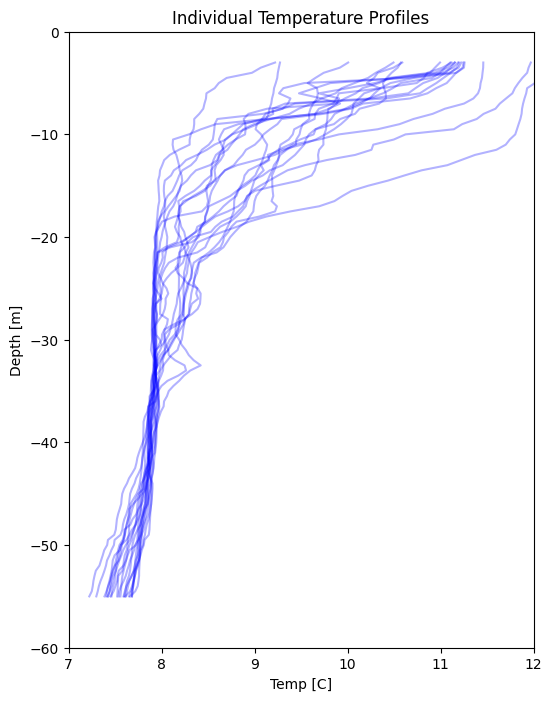

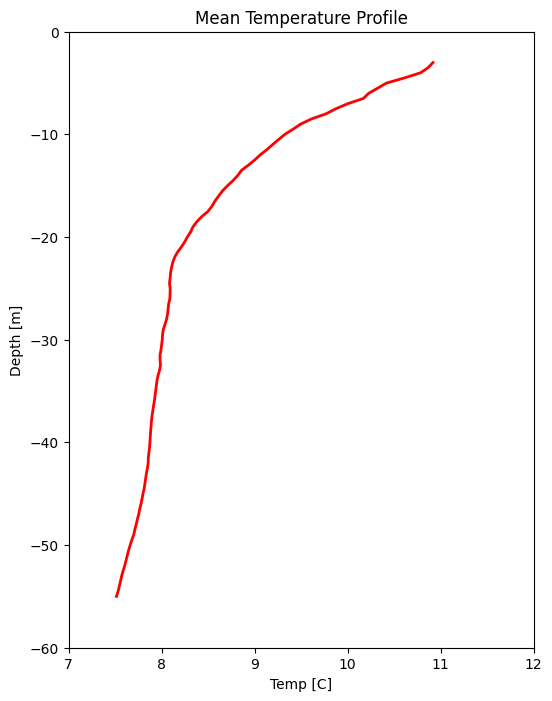

In [4]:
# Python
# --- Figure 1: Individual Temperature Profiles ---
# All values are (time, depth)
# We want to plot depth on y-axis, temp on x-axis)
plt.figure(figsize=(6,8))
for drop in range(temp.shape[0]):
    plt.plot(temp[drop,:], depth, color='blue', alpha=0.3)
plt.xlim([7, 12])
plt.ylim([-60, 0])
plt.gca().invert_yaxis()
plt.xlabel('Temp [C]')
plt.ylabel('Depth [m]')
plt.title('Individual Temperature Profiles')
plt.gca().invert_yaxis()  # Depth increasing downward
plt.show()

# --- Figure 2: Average Temperature Profile ---
plt.figure(figsize=(6,8))
# Average across time axis (axis=0) to get mean profile
temp_mean = np.mean(temp, axis=0)
plt.plot(temp_mean, depth, color='red', linewidth=2)
plt.xlim([7, 12])
plt.ylim([-60, 0])
plt.gca().invert_yaxis()
plt.xlabel('Temp [C]')
plt.ylabel('Depth [m]')
plt.title('Mean Temperature Profile')
plt.gca().invert_yaxis()
plt.show()

### Show Salinity profiles, and average salinity profile
We can see the profiles, and quickly find the average profile using "mean"

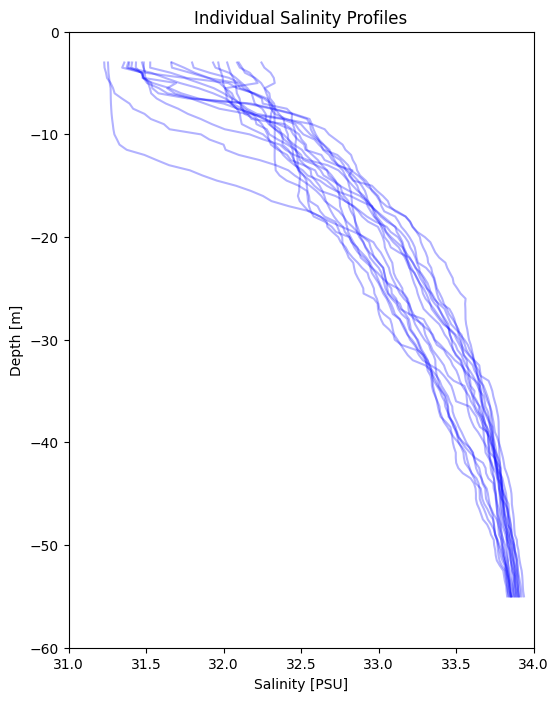

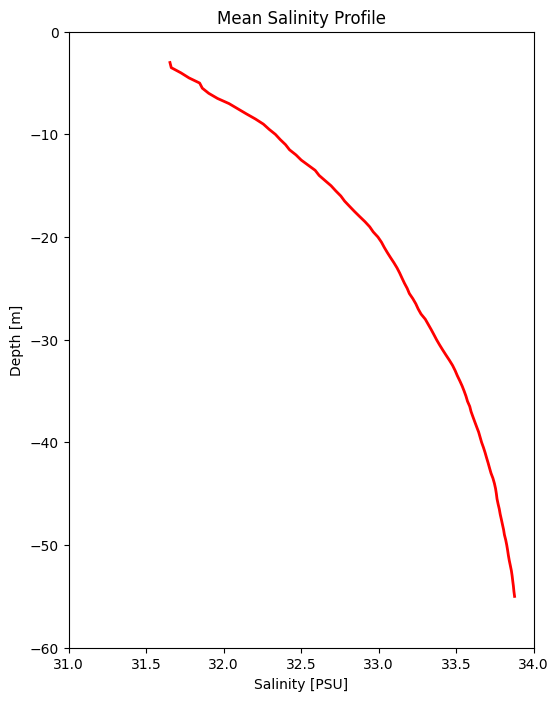

In [5]:
# Python 
# --- Figure 2 Individual salinity Profiles ---
# All values are (time, depth)
# We want to plot depth on y-axis, salinity on x-axis)
plt.figure(figsize=(6,8))
for drop in range(sal.shape[0]):
    plt.plot(sal[drop,:], depth, color='blue', alpha=0.3)
plt.xlim([31, 34])
plt.ylim([-60, 0])
plt.gca().invert_yaxis()
plt.xlabel('Salinity [PSU]')
plt.ylabel('Depth [m]')
plt.title('Individual Salinity Profiles')
plt.gca().invert_yaxis()  # Depth increasing downward
plt.show()

# --- Figure 2: Average Salinity Profile ---
plt.figure(figsize=(6,8))
# Average across time axis (axis=0) to get mean profile
sal_mean = np.mean(sal, axis=0)
plt.plot(sal_mean, depth, color='red', linewidth=2)
plt.xlim([31, 34])
plt.ylim([-60, 0])
plt.gca().invert_yaxis()
plt.xlabel('Salinity [PSU]')
plt.ylabel('Depth [m]')
plt.title('Mean Salinity Profile')
plt.gca().invert_yaxis()
plt.show()

### Calculate Density
Calculate Density using the Gibbs-Seawater Oceanographic Toolbox (GSW), which we installed in Python with ```pip install gsw```

TEOS needs "Absolute Salinity" and "Conservative Temperature". 

The values for lat and lon are taken from the global attributes of the netCDF file.

In [7]:
# Python
# Calculate Density
# Calculate Density using the [Gibbs-Seawater Oceanographic Toolbox (GSW)]

# --- location (from netCDF file)---
lon = -124.3059
lat = 44.6350

# --- Convert depth to pressure ---
p = gsw.p_from_z(depth, lat)  # pressure in dbar

# TEOS needs "Absolute Salinity" and "Conservative Temperature". 
# We can convert from Practical Salinity and in-situ temperature
# to Absolute Salinity and Cons
#
# --- Convert Practical Salinity to Absolute Salinity ---
SA = gsw.SA_from_SP(sal, p, lon, lat)

# --- Convert in-situ temperature to Conservative Temperature ---
CT = gsw.CT_from_t(SA, temp, p)

# --- Compute in-situ density [kg/m^3] ---
rho_calc = gsw.rho(SA, CT, p)

### Checking  and viewing our answer

Lets compare our calculation to the value in the netCDF file, to see if our calculation is equivalent to theirs ( or close enough ).

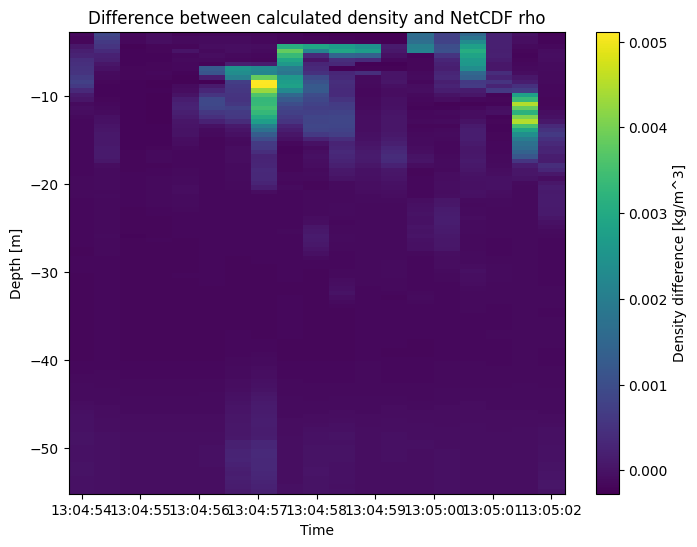

In [8]:
# --- Compare with NetCDF density ---
diff = rho_calc - rho

# --- Plot the difference ---
plt.figure(figsize=(8,6))
plt.pcolor(time, depth, diff.T, shading='auto')  # diff.T if needed
plt.colorbar(label='Density difference [kg/m^3]')
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title('Difference between calculated density and NetCDF rho')
plt.show()


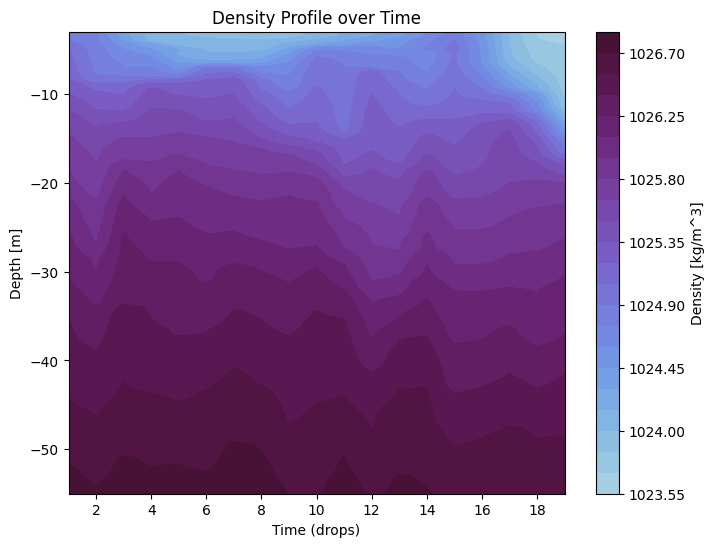

In [9]:
# Python
# --- Plotting full densities ---
plt.figure(figsize=(8,6))
# Make a filled contour plot (depth vs. time)
# Time is in seconds since 1900, lets just call them "drops 1-19"
drops = np.arange(1, len(time)+1)
plt.contourf(drops, depth, rho.T, levels=30, cmap='cmo.dense')  # rho.T if needed
plt.colorbar(label='Density [kg/m^3]')
plt.clim(1023, 1027)  # same as vmin/vmax
plt.xlabel('Time (drops)')
plt.ylabel('Depth [m]')
plt.title('Density Profile over Time')
plt.show()

### Compare the three profiles

We can compare the average temperature, salinity, and density in one plot.

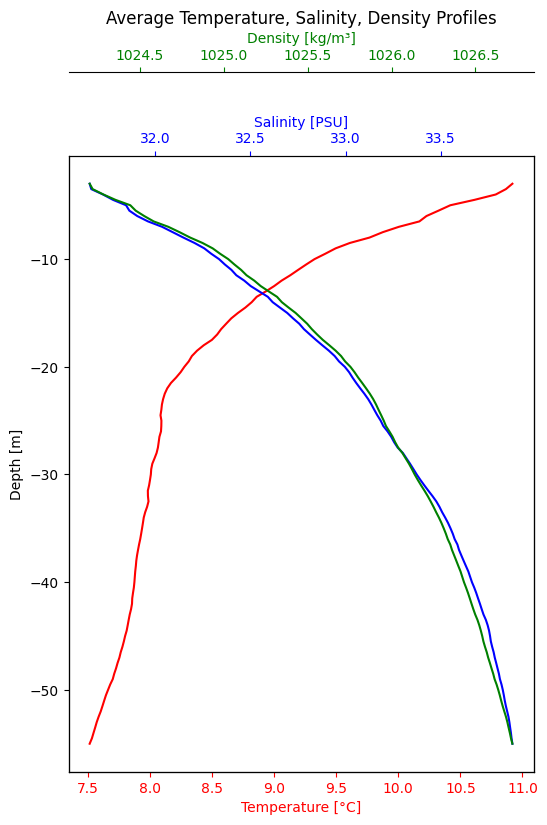

In [11]:
# Python
# --- Plotting Average Profiles of Temp, Sal, Density ---
# We will use twinx to make multiple x-axes
rho_mean = np.mean(rho, axis=0)

fig, ax1 = plt.subplots(figsize=(6,8))

ax1.plot(temp_mean, depth, 'r-', label='Temp [°C]')
ax1.set_xlabel('Temperature [°C]', color='r')
ax1.set_ylabel('Depth [m]')
ax1.tick_params(axis='x', colors='r')

# Second x-axis for salinity
ax2 = ax1.twiny()
ax2.plot(sal_mean, depth, 'b-', label='Salinity [PSU]')
ax2.set_xlabel('Salinity [PSU]', color='b')
ax2.tick_params(axis='x', colors='b')

# Third x-axis for density (trick: offset it)
ax3 = ax1.twiny()
ax3.spines['top'].set_position(('outward', 60))  # move axis outward
ax3.plot(rho_mean, depth, 'g-', label='Density [kg/m³]')
ax3.set_xlabel('Density [kg/m³]', color='g')
ax3.tick_params(axis='x', colors='g')

plt.title('Average Temperature, Salinity, Density Profiles')
plt.show()